# Subwavelength polarizing diffraction gratings
This tutorial analyzed how

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import hickle as hkl
import copy

from pprint import  pprint

np.set_printoptions(precision=3)

In [3]:
from py_lipss.old.pyS4 import simS4, nanoxz
from py_lipss.old.utils import plotters

In [4]:
from py_lipss.old.computation import compute_3_structures

from py_lipss.old.polarization_parameters import (get_jones_2d, get_stokes_from_E,
                                                get_jones_from_grt,
                                                polarization_reflection_experiment,
                                                get_stokes_from_grt)
from py_lipss.old.field_parameters import get_efficiency_reflectance, get_E_1D, get_E_0D
from py_lipss.old.utils_drawing import plot_Jones_ellipses_in_out,plot2D_E2H2, plot2D_eps


## Binary structure

We are going to test the polarizing propierties of steel subgratings of 580 nm
of lattice parameter, under a monochromatic plane wave of 850 nm. The structure
and the substrate is made of Steel (FCC) from Fagor. The refractive index 
was experimentally measured\cite{sup:materials} is: $n=2.8, k=3.96$. In this notebook 
a binary grating is analyzed. 


In [5]:
# Defining parameters
um = 1.
mm = 1e3
nm = 1e-3

a = 0.580 * um  #[\mu m] lattice parameter in microns
H = 0.3427 * um  #[\mu m] Thickness of the grating
#w = 5. #[\mu m] width of the prism
wavelength = 0.85 * um  #[\mu m] incident wavelength

G = 21  #31  # Truncation in k-space
NP = 200  # resolution of the fields

G = 9  # Truncation in k-space
NP = 50  # resolution of the fields

In [6]:
nsteel = 2.75088646
ksteel = 3.87804413

epssteel = nsteel**2 - ksteel**2 + 2 * nsteel * ksteel * 1j
materials = {"Vacuum": 1.0, "Steel": epssteel}

In [7]:
layers = [
    {
        "Name": "l0",
        "Thickness": 0.,
        "Material": "Vacuum"
    },
    {
        "Name": "l1",
        "Thickness": H,
        "Material": "Vacuum"
    },
    {
        "Name": "l2",
        "Thickness": 0.,
        "Material": "Steel"
    },
]
patterns = [{
    "Rectangle": {
        "Layer": "l1",
        "Material": "Steel",
        "Center": (0, 0),
        "Angle": 0.,
        "Halfwidths": (a * 0.39 / 2., 0)
    }
}]

In [8]:
# Define the structure using py_lipss
options = {"PolarizationDecomposition": False, "Verbosity": 0}
grating = simS4.Patterned(a, G=G, options=options)
grating.set_materials(materials=materials)
grating.set_layers(layers)
grating.set_patterns(patterns)
grating.set_excite(wavelength)
#orders_list = grating.orders_list

In [9]:
talbot_length = 2* a**2 / wavelength
#z = np.linspace(-0.1*(talbot_length), 0.1*(talbot_length)+ H, NP)
z = np.linspace(-2., H + 2., NP)
x = np.linspace(-a / 2, a / 2., NP)

In [10]:
grating.get_fluxes()
grating.get_amps()
grating.get_fields(x=x, y=[0], z=z)
grating.get_epsilon(x=x, y=[0], z=z)
grating.a = grating._a
grating.z = z

In [11]:
plt.rcParams['axes.grid'] = False


grating2,no_grating,no_cell = compute_3_structures(grating)

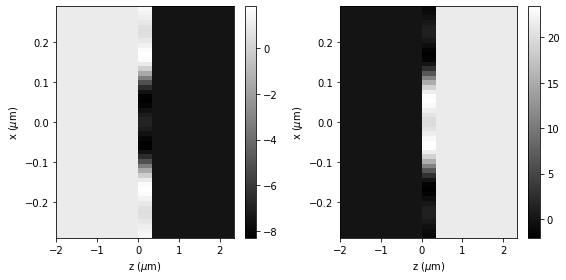

In [12]:
plot2D_eps(grating)


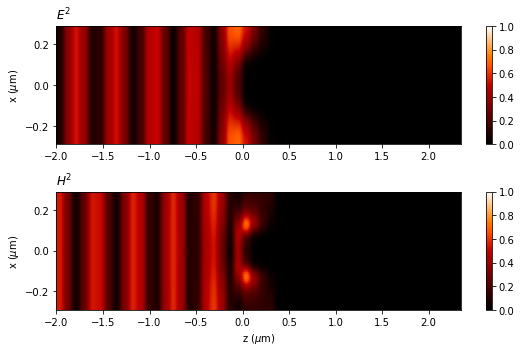

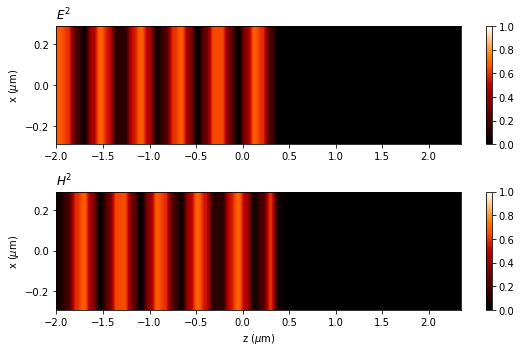

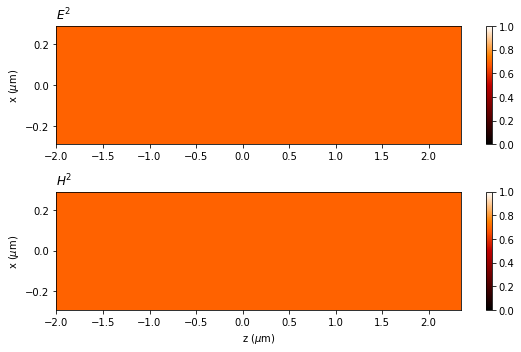

In [13]:
plot2D_E2H2(grating);
plot2D_E2H2(no_grating);
plot2D_E2H2(no_cell);

In [14]:
# Setting the nanostructure to test
grt = copy.deepcopy(grating)
grt.stop(clear_results=True)
grt.source['pAmplitude'] = 1 / np.sqrt(2)
grt.source['sAmplitude'] = 1. / np.sqrt(2.)
grt.get_fields(0, 0, z=np.linspace(-200 * wavelength, -198. * wavelength, NP))
grt.get_fluxes()
grt.start(run_calcs=True)

In [15]:
grt2, no_grating,no_cell = compute_3_structures(grt)

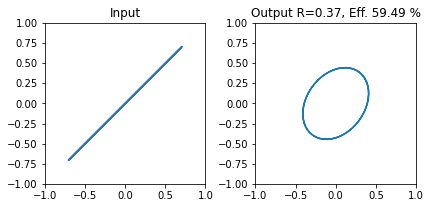

In [16]:
fig=plot_Jones_ellipses_in_out(grt2, no_cell, no_grating )

In [17]:
E = grt2.fields[:,0,0,0] - no_cell.fields[:,0,0,0]
E0 = no_cell.fields[:,0,0,0]

In [18]:
print(grt2.fields.shape)

(50, 1, 1, 2, 3)


In [22]:
print(E.shape)
print(E.sum(axis=0).shape)

(50, 3)
(3,)


In [23]:
E_1D=get_E_1D(grt2, no_grating, no_cell)
stk1=get_stokes_from_E(E_1D.sum(axis=0))
print(stk1)

[ 1.     0.081  0.022 -0.996]


In [24]:
E_0D=get_E_0D(grt2, no_grating, no_cell)
stk1=get_stokes_from_E(E_0D)
print(stk1)

[ 1.     0.081  0.022 -0.996]


In [25]:
stk0=get_stokes_from_E(E0.sum(axis=0))
print(stk0)

[ 1.  0.  1.  0.]


In [26]:
get_stokes_from_grt(grt2)

(array([ 1.,  0.,  1.,  0.]), array([ 1.   ,  0.081,  0.022, -0.996]))

In [27]:
stks, R0, eta = polarization_reflection_experiment(grt)
pprint((stks, R0, eta))

(array([ 1.   ,  0.081,  0.022, -0.996]),
 0.43690715993281926,
 0.70244558530120771)


In [28]:
J0, J1 =  get_jones_from_grt(grt)
print(J0)

[ 0.707 +5.923e-14j  0.707 +5.923e-14j]


In [29]:
print(J1/J1[0])

[ 1.00-0.j     0.02+0.922j]


## Polarization output map for linear polarization at 45 deg

### Local Run (Single Thread)

In [42]:
NP_map = 60 #30
Hs = np.linspace(0.0, 1., NP_map)
FF = np.linspace(0.0, 1., NP_map)
stokes_map = np.zeros((NP_map,NP_map,3))
R_map = np.zeros((NP_map,NP_map))
eta_map = np.zeros((NP_map, NP_map))

In [43]:
#%px reload(structures.simS4)
xds = []
for i, h in enumerate(Hs):
    for j, fill_factor in enumerate(FF):
        #grt = copy.deepcopy(grating)
        grt.stop()
        grt.patterns[0]["Rectangle"]["Halfwidths"] = (fill_factor / 2. * a, 0)
        grt.layers[1]["Thickness"] = h
        stks, R0, eta = polarization_reflection_experiment(grt)
        stokes_map[i,j,:] = stks[1:]
        R_map[i,j] = R0
        eta_map[i,j] = eta

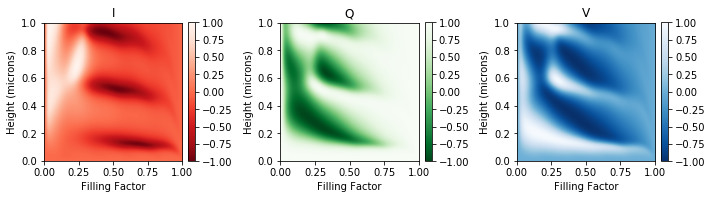

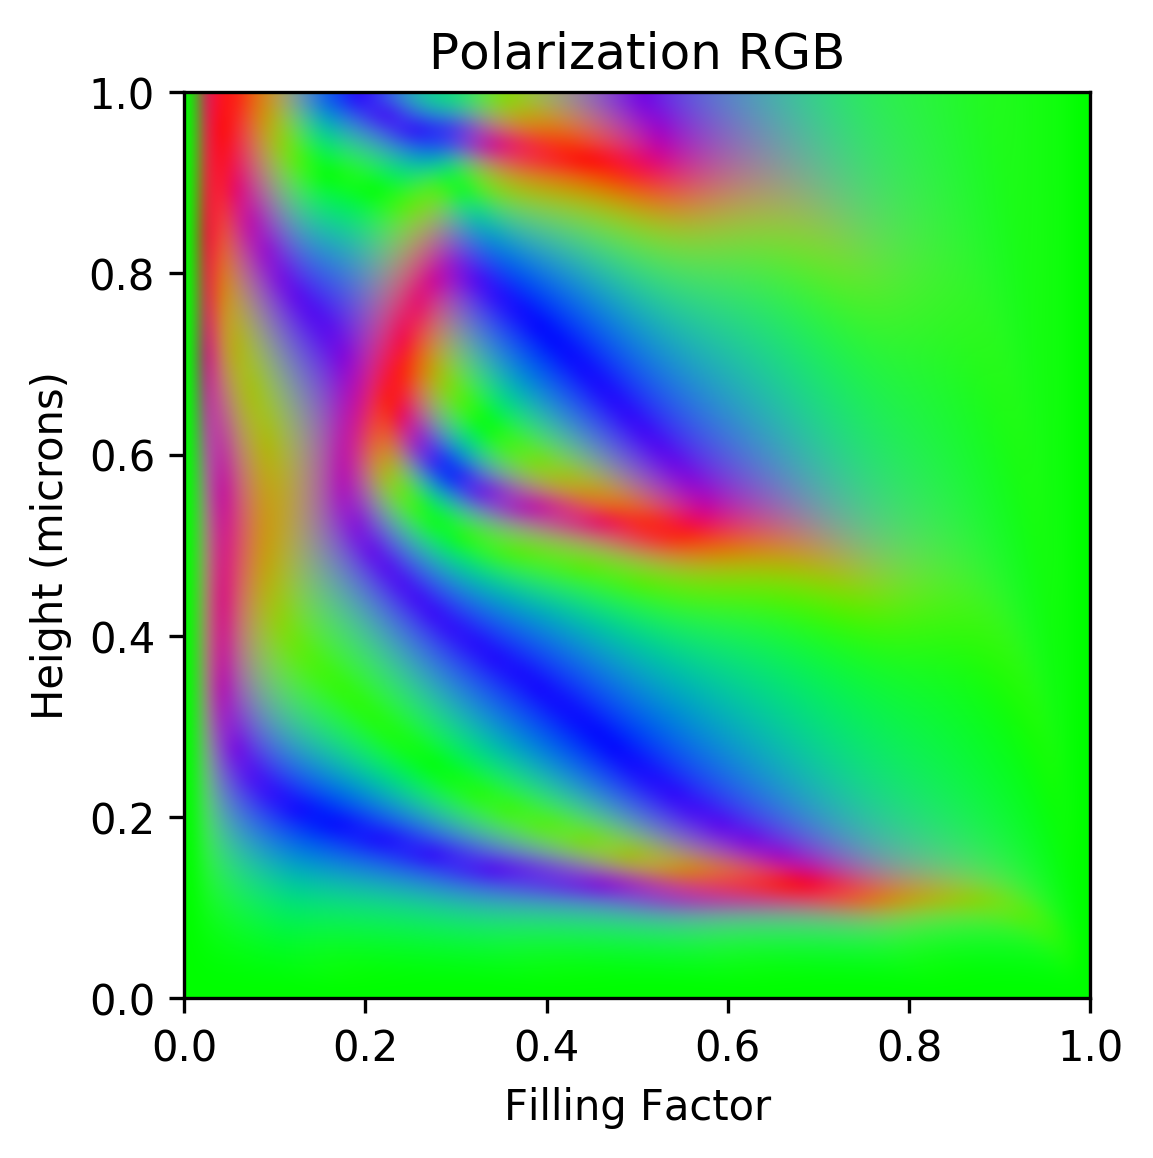

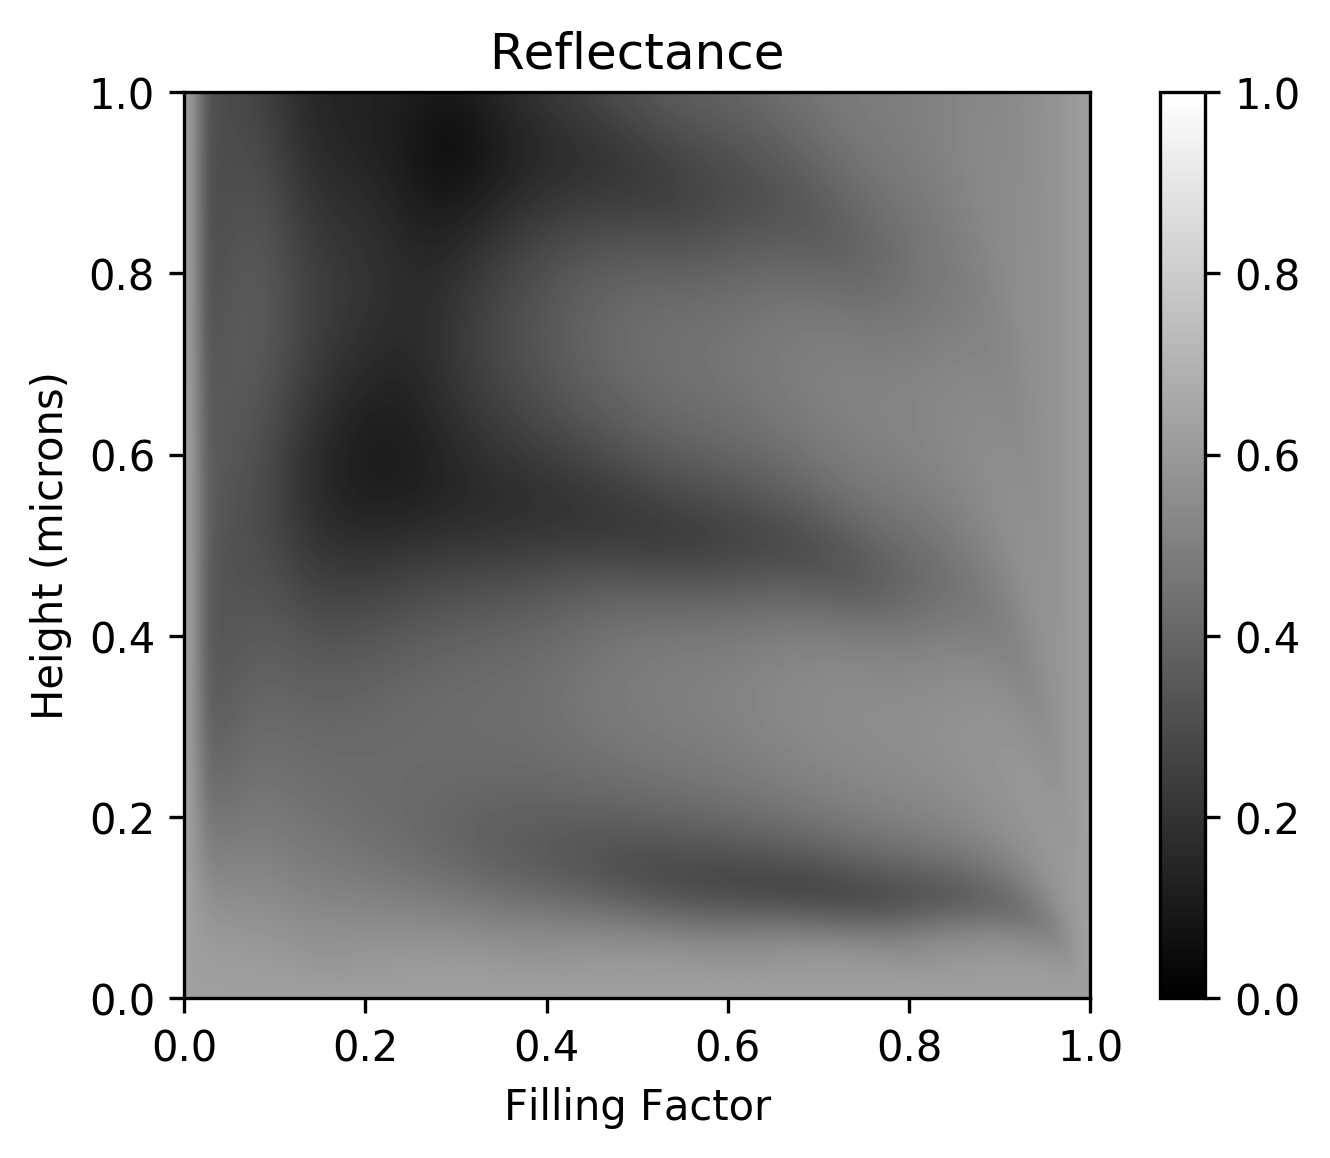

In [51]:
titles = "I Q V".split()
cmaps = ["Reds_r","Greens_r","Blues_r"]
params ={"extent":[0, 1, 0, 1],
         "aspect":'equal',
         "interpolation":'bicubic',
         "origin": 'lower',
         "vmin":-1,
         "vmax":1}

xlabel= "Filling Factor"
ylabel= "Height (microns)"
fg = plotters.imshow_serial(
    stokes_map.real, (1, 3),
    xlabel= xlabel,
    ylabel= ylabel,
    last_axis=True, 
    figargs={"figsize":(10,20), "dpi":72},
    titles=titles,
    cmaps=cmaps,
    params=params)
#plot_polarization(stokes_paralel_cos.real, R_map_paralel_cos.T)
fg = plt.figure(dpi=300)
ax = fg.add_subplot(111)
ax.imshow(abs(stokes_map.real),**params)
ax.set_title("Polarization RGB")
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)

fg = plt.figure(dpi=300)
ax = fg.add_subplot(111)
params['cmap']='binary_r'
params['vmin']=0
imR = ax.imshow(R_map, **params)
ax.set_title("Reflectance")
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
fg.colorbar(imR)
#fg, fg2 = plot_polarization(stokes_map, R_map)

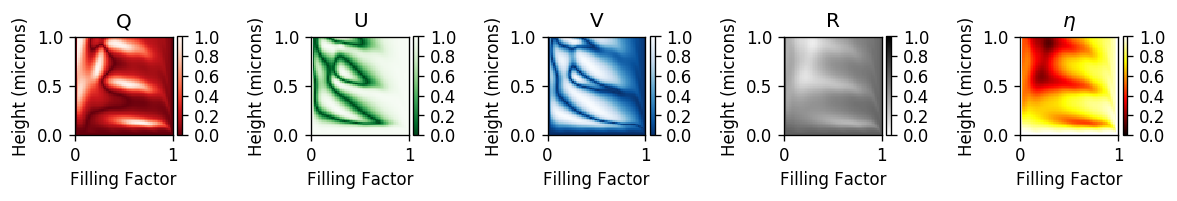

In [45]:
lala = np.array(R_map)
lala = np.concatenate([R_map[:,:,np.newaxis],eta_map[:,:,np.newaxis]],axis=2)
lala = np.concatenate([np.abs(stokes_map),lala],axis=2)
lala.shape

titles = "Q U V R $\eta$".split()
cmaps = ["Reds_r","Greens_r","Blues_r", "binary", "hot"]
params ={"extent":[0, 1, 0, 1],
         "aspect":'equal',
         "interpolation":'none',
         "origin": 'lower',
         "vmin":0,
         "vmax":1}

xlabel= "Filling Factor"
ylabel= "Height (microns)"
fg = plotters.imshow_serial(
    lala, (1, 5),
    xlabel= xlabel,
    ylabel= ylabel,
    last_axis=True, 
    figargs={"figsize":(10,20), "dpi":120},
    titles=titles,
    cmaps=cmaps,
    params=params)


# Conclusions and further research

Los dos brazos pueden ser por el área del motivo, siendo los dos brazos, dos modos distintos. la zona central nos dice que esta cuantizado. Tambien puede estar relacionado con el indice efectivo que depende a su vez del area. Hay que ver tambien si es muy sensible al medio.

La zona roja de la parte superior corresponde con una polarizacion horizontal, mientras que la zona roja inferior con vertical, ver diagramas separados. Los brazos azules circulares el inferior gira a derechas y el superior a izquierdas. 
La  estructura sinosuidal presenta independencia con el filling factor para valores mayores que 0.5, dependiendo de la altura del sistema. Parece un sistema casi puro de desfase ya que la reflectividad en ese caso es bastante plana. Hay que tener en cuenta que el sistema sinosuidal el filling factor viene definido por la anchura de la base, siendo un rellenado del volumen máximo de un 0.5 comparado con el sistema de la grating binaria. 

Las dos estructuras presentan un comportamiento similar para sistemas con poco filling factor, ya que geométricamente los dos sistemas tienden a una delta, con una resonancia muy marcada. En los dos casos puede deberse a una absorción del plasmón. En el sistema sinosuidal es menos acusado.